# Importing Libraries

In [142]:
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


In [93]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])
# print(os.environ['SHELL'])


dslab


# Loading Data

Select the dataset you want to work with by setting the variable 'dataset_name'

In [119]:
def read_HSI(dataset):
    if dataset == 'Salinas':
        data = loadmat('../Datasets/Salinas/Salinas_corrected.mat')['salinas_corrected']
        gt = loadmat('../Datasets/Salinas/Salinas_gt.mat')['salinas_gt']
        print(f"data shape: {data.shape}\ngt shape: {gt.shape}")
        return data, gt
    elif dataset == 'IndianPines':
        data = loadmat('../Datasets/IndianPines/Indian_pines_corrected.mat')['indian_pines_corrected']
        gt = loadmat('../Datasets/IndianPines/Indian_pines_gt.mat')['indian_pines_gt']
        print(f"data shape: {data.shape}\ngt shape: {gt.shape}")
        return data, gt
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  # df.to_csv(f'./Datasets/Raw/{dataset_name}/{dataset_name}.csv')
  return df
    
# dataset_name = 'IndianPines'
dataset_name = 'Salinas'
data, gt = read_HSI(dataset=dataset_name)

df = extract_pixels(data, gt)
print(f"df shape: {df.shape}")

if dataset_name == 'Salinas':
    class_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                    'Fallow_rough_plow','Fallow_smooth','Stubble','Celery',
                    'Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green',
                    'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk',
                    'Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
elif dataset_name == 'IndianPines':
    class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                    "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats",
                    "Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat",
                    "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    


data shape: (512, 217, 204)
gt shape: (512, 217)
df shape: (111104, 205)


# Visualizing Dataset

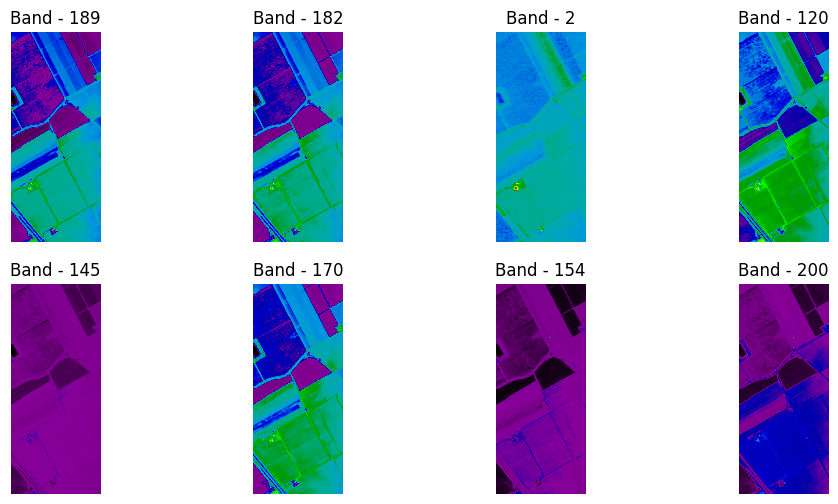

In [120]:
#Spectral bands
fig = plt.figure(figsize = (12, 6))

for i in range(1, 8+1):
    fig.add_subplot(2,4, i)
    q = np.random.randint(data.shape[2])
    plt.imshow(data[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


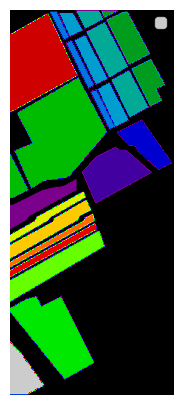

In [121]:
# Ground Truth
plt.figure(figsize=(10, 5))
plt.imshow(gt, cmap='nipy_spectral')
# plt.colorbar
plt.legend()
plt.axis('off')
plt.show()

# Dimensionality Reduction

## Utils

In [164]:
def show_random_bands(df_dr):
    fig = plt.figure(figsize = (20, 10))

    random_bands = random.sample(range(1, df_dr.shape[1]), 8)
    for i in range(1, 8+1):
        fig.add_subplot(2,4, i)
        plt.imshow(df_dr.loc[:, f'Band-{random_bands[i-1]}'].values.reshape(y.shape[0], y.shape[1]), cmap='nipy_spectral')
        plt.axis('off')
        plt.title(f'Band - {random_bands[i-1]}')

def apply_DR(df, method, n_components):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1:].values

    if method == 'PCA':
        pca = PCA(n_components = n_components, random_state=0)
        dt = pca.fit_transform(X)
    elif method == 'FastICA':
        fast_ica = FastICA(n_components=n_components, whiten='unit-variance', max_iter=400, random_state=0)
        dt = fast_ica.fit_transform(X)
    elif method == 'UMAP':
        umap_reducer = umap.UMAP(n_components=n_components)
        dt = umap_reducer.fit_transform(X)
    elif method == 'TSNE':
        tsne = TSNE(n_components=n_components, method='exact', learning_rate='auto', init='random', perplexity=3)
        dt = tsne.fit_transform(X)
        
    dr_df = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
    dr_df.columns = [f'Band-{i}' for i in range(1,n_components+1)]+['class']

    return dr_df

In [123]:
n_components = 8

## PCA

In [124]:
def save_data(method, dr_df, X, n_components):
    # saving to .mat
    reshaped_data = np.array([row[1][:-1] for row in dr_df.iterrows()]).reshape((X.shape[0], X.shape[1], n_components))
    savemat(f'../Datasets/{dataset_name}/{dataset_name}_{method}_{n_components}.mat', {'data': reshaped_data})

In [165]:
method='PCA'
dr_df = apply_DR(df, method=method, n_components=n_components)
# show_random_bands(dr_df)
save_data(method, dr_df, data, n_components)
dr_df.head()

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,-6136.415770,-4385.651601,628.426690,-302.089387,-7.164320,48.222012,-129.801973,-28.045864,0
1,-6196.986718,-4360.590266,568.289463,-269.925094,-1.914969,-13.422142,-141.516132,-48.425748,0
2,-6359.538817,-4693.892811,578.047775,-286.413937,18.366365,-17.493501,-122.449201,-23.107802,0
3,-6583.700658,-5103.974489,630.466845,-313.787607,39.673922,-9.386642,-130.574810,-14.943106,0
4,-6834.644650,-5385.604040,666.876042,-327.332038,24.787586,-19.604360,-134.531359,-30.850479,0


## FastICA

In [131]:
method='FastICA'
dr_df = apply_DR(df, method=method, n_components=n_components)
# show_random_bands(dr_df)
save_data(method, dr_df, data, n_components)
dr_df.head()

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,1.335208,-0.142253,0.755461,-0.100093,1.039744,-0.260446,1.028922,0.033928,0
1,1.393530,-0.434703,0.631693,-0.048043,1.045360,-0.004241,1.057971,0.159134,0
2,1.319765,-0.334693,0.625405,0.069177,1.055289,-0.036243,1.064955,-0.135156,0
3,1.410656,-0.261351,0.638957,0.122732,1.121327,-0.097339,1.166500,-0.202448,0
4,1.462530,-0.410069,0.656864,0.035838,1.202083,-0.070394,1.224814,-0.143898,0


## UMAP

In [ ]:
method='UMAP'
dr_df = apply_DR(df, method=method, n_components=n_components)
# show_random_bands(dr_df)
save_data(method, dr_df, data, n_components)
dr_df.head()

## T-SNE

In [ ]:
# PROBLEM: Causing MemoryError: Unable to allocate 46.0 GiB for an array with shape (111104, 111104) and data type float32


# method='TSNE'
# dr_df = apply_DR(df, method=method, n_components=n_components)
# # show_random_bands(dr_df)
# save_data(method, dr_df, data, n_components)


# Feature Selection

## Correlation Based

In [170]:
method = 'Corr'

corr_matrix = df.corr()
corr_with_target = corr_matrix['class']

top_k = corr_with_target.abs().sort_values(ascending=False)[:n_components+1].index
dr_df = df[top_k]

save_data(method, dr_df, data, n_components)
dr_df.head()

,class,band5,band6,band7,band4,band8,band9,band10,band11
0,0,1316,1397,1319,1041,1462,1643,1683,1656
1,0,1316,1352,1319,1041,1462,1643,1683,1656
2,0,1286,1352,1300,1041,1412,1614,1644,1632
3,0,1316,1374,1280,999,1380,1584,1631,1596
4,0,1286,1352,1261,999,1396,1555,1618,1596
